In [28]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import glob
import os

data_raw_dir = "../data/raw/"
data_processed_dir = "../data/processed/"

print("Loading INMET in-situ data...")
inmet_data = pd.read_csv(f"{data_processed_dir}inmet_hourly_data_se_sp_2000_2025.csv", 
                         parse_dates=['datetime'], index_col='datetime')

stations_meta = pd.read_csv(f"{data_processed_dir}inmet_stations_metadata_se_sp_2000_2025.csv")

print(f"INMET data shape: {inmet_data.shape}")
print(f"Stations: {len(stations_meta)} stations")
print(f"Station IDs: {sorted(stations_meta['station_id'].unique())}")
print(f"Date range: {inmet_data.index.min()} to {inmet_data.index.max()}")
print(f"Variables: {list(inmet_data.columns)}")


Loading INMET in-situ data...
INMET data shape: (5850336, 24)
Stations: 42 stations
Station IDs: ['A701', 'A705', 'A706', 'A707', 'A708', 'A711', 'A712', 'A713', 'A714', 'A715', 'A716', 'A718', 'A725', 'A726', 'A727', 'A728', 'A729', 'A733', 'A734', 'A735', 'A736', 'A737', 'A738', 'A739', 'A740', 'A741', 'A744', 'A746', 'A747', 'A748', 'A753', 'A755', 'A762', 'A763', 'A764', 'A765', 'A766', 'A767', 'A768', 'A769', 'A770', 'A771']
Date range: 2001-08-30 00:00:00 to 2025-10-31 23:00:00
Variables: ['precipitation', 'atmospheric_pressure', 'max_atmospheric_pressure', 'min_atmospheric_pressure', 'global_radiation', 'air_temperature', 'dew_point_temperature', 'max_air_temperature', 'min_air_temperature', 'max_dew_point_temperature', 'min_dew_point_temperature', 'max_relative_humidity', 'min_relative_humidity', 'relative_humidity', 'wind_direction', 'max_wind_gust', 'wind_speed', 'station_id', 'station_name', 'year', 'latitude', 'longitude', 'altitude', 'RADIACAO GLOBAL (Kj/m²)']


In [13]:
inmet_start_year = inmet_data.index.min().year
inmet_end_year = inmet_data.index.max().year

print(f"INMET date range: {inmet_start_year} to {inmet_end_year}")

print("\nSearching for ERA5 files...")
all_era5_files = sorted(glob.glob(f"{data_raw_dir}era5_tmax_daily_*_area_6N_-74W_-34S_-33E.nc"))

era5_files_to_load = []
for file in all_era5_files:
    year = int(os.path.basename(file).split('_')[3])
    if inmet_start_year <= year <= inmet_end_year:
        era5_files_to_load.append(file)

print(f"Total ERA5 files available: {len(all_era5_files)}")
print(f"ERA5 files needed: {len(era5_files_to_load)}")

if len(era5_files_to_load) == 0:
    print("ERROR: No ERA5 files found for the INMET period!")
else:
    print(f"\nExtracting ERA5 data at station locations year by year...")
    print(f"Station coordinates:")
    for _, station in stations_meta.iterrows():
        print(f"  {station['station_id']}: ({station['latitude']:.2f}, {station['longitude']:.2f})")
    
    era5_at_stations = []
    
    for file_path in era5_files_to_load:
        year = os.path.basename(file_path).split('_')[3]
        print(f"\nProcessing year {year}...")
        
        ds_year = xr.open_dataset(file_path)
        ds_year['t2m_celsius'] = ds_year['t2m'] - 273.15
        
        for _, station in stations_meta.iterrows():
            station_id = station['station_id']
            lat = station['latitude']
            lon = station['longitude']
            
            era5_station = ds_year.sel(latitude=lat, longitude=lon, method='nearest')
            
            era5_df = era5_station['t2m_celsius'].to_dataframe().reset_index()
            era5_df['station_id'] = station_id
            era5_df['station_lat'] = lat
            era5_df['station_lon'] = lon
            era5_df['era5_lat'] = float(era5_station['latitude'].values)
            era5_df['era5_lon'] = float(era5_station['longitude'].values)
            
            era5_df = era5_df.rename(columns={'t2m_celsius': 'era5_tmax', 'time': 'date'})
            
            era5_at_stations.append(era5_df)
        
        ds_year.close()
        del ds_year
        
        print(f"  Year {year} processed. Current data size: {len(era5_at_stations)} station-years")
    
    era5_stations_df = pd.concat(era5_at_stations, ignore_index=True)
    
    print(f"\nERA5 extraction completed:")
    print(f"  Final dataset shape: {era5_stations_df.shape}")
    print(f"  Columns: {list(era5_stations_df.columns)}")
    
    date_col = 'date' if 'date' in era5_stations_df.columns else 'time'
    if date_col in era5_stations_df.columns:
        print(f"  Date range: {era5_stations_df[date_col].min()} to {era5_stations_df[date_col].max()}")
        print(f"  Stations: {era5_stations_df['station_id'].nunique()}")
        
        print(f"\nSample ERA5 data:")
        print(era5_stations_df.head())
    else:
        print("  ERROR: No time/date column found!")
        print(f"  Available columns: {list(era5_stations_df.columns)}")

INMET date range: 2001 to 2025

Searching for ERA5 files...
Total ERA5 files available: 31
ERA5 files needed: 25

Extracting ERA5 data at station locations year by year...
Station coordinates:
  A705: (-22.36, -49.03)
  A708: (-20.58, -47.38)
  A706: (-22.75, -45.60)
  A707: (-22.12, -51.40)
  A714: (-23.98, -48.89)
  A715: (-23.85, -48.16)
  A711: (-21.98, -47.88)
  A725: (-23.10, -48.95)
  A716: (-22.95, -49.89)
  A712: (-24.72, -47.55)
  A727: (-21.67, -49.73)
  A713: (-23.35, -47.67)
  A718: (-22.37, -50.97)
  A726: (-22.70, -47.62)
  A728: (-23.04, -45.52)
  A729: (-20.40, -49.97)
  A701: (-23.48, -46.62)
  A739: (-22.41, -46.81)
  A737: (-21.86, -48.67)
  A735: (-21.09, -49.92)
  A738: (-21.78, -47.08)
  A733: (-20.16, -50.59)
  A740: (-23.23, -45.42)
  A734: (-21.32, -50.93)
  A736: (-21.13, -48.84)
  A746: (-24.96, -48.42)
  A747: (-21.34, -48.11)
  A741: (-22.37, -48.56)
  A753: (-20.36, -47.77)
  A748: (-20.56, -48.54)
  A755: (-23.52, -46.87)
  A762: (-21.46, -51.55)
  A764:

In [14]:
print("Processing INMET data to daily maximum temperatures...")

temp_cols = ['air_temperature', 'max_air_temperature']
available_temp_cols = [col for col in temp_cols if col in inmet_data.columns]

print(f"Available temperature columns: {available_temp_cols}")

for col in available_temp_cols:
    inmet_data[col] = pd.to_numeric(inmet_data[col], errors='coerce')

inmet_daily = (inmet_data.groupby(['station_id', pd.Grouper(freq='D')])
               [available_temp_cols]
               .max()
               .reset_index())

inmet_daily = inmet_daily.rename(columns={'datetime': 'date'})

print(f"\nINMET daily data processed:")
print(f"  Shape: {inmet_daily.shape}")
print(f"  Date range: {inmet_daily['date'].min()} to {inmet_daily['date'].max()}")
print(f"  Stations: {inmet_daily['station_id'].nunique()}")
print(f"  Columns: {list(inmet_daily.columns)}")


Processing INMET data to daily maximum temperatures...
Available temperature columns: ['air_temperature', 'max_air_temperature']

INMET daily data processed:
  Shape: (243764, 4)
  Date range: 2001-08-30 00:00:00 to 2025-10-31 00:00:00
  Stations: 42
  Columns: ['station_id', 'date', 'air_temperature', 'max_air_temperature']


In [15]:
print("Merging INMET and ERA5 data for comparison...")

print(f"ERA5 columns: {list(era5_stations_df.columns)}")
print(f"INMET columns: {list(inmet_daily.columns)}")

temp_col = 'max_air_temperature' if 'max_air_temperature' in inmet_daily.columns else 'air_temperature'
inmet_comparison = inmet_daily[['station_id', 'date', temp_col]].copy()
inmet_comparison = inmet_comparison.rename(columns={temp_col: 'inmet_tmax'})

era5_comparison = era5_stations_df[['station_id', 'valid_time', 'era5_tmax']].copy()
era5_comparison = era5_comparison.rename(columns={'valid_time': 'date'})

inmet_comparison['date'] = pd.to_datetime(inmet_comparison['date'])
era5_comparison['date'] = pd.to_datetime(era5_comparison['date'])

print(f"\nINMET data: {inmet_comparison.shape} records")
print(f"ERA5 data: {era5_comparison.shape} records")
print(f"INMET date range: {inmet_comparison['date'].min()} to {inmet_comparison['date'].max()}")
print(f"ERA5 date range: {era5_comparison['date'].min()} to {era5_comparison['date'].max()}")
print(f"INMET stations: {sorted(inmet_comparison['station_id'].unique())}")
print(f"ERA5 stations: {sorted(era5_comparison['station_id'].unique())}")

common_stations = set(inmet_comparison['station_id'].unique()) & set(era5_comparison['station_id'].unique())
print(f"Common stations: {sorted(common_stations)}")

comparison_df = pd.merge(inmet_comparison, era5_comparison, 
                        on=['station_id', 'date'], how='inner')

comparison_df = comparison_df.dropna(subset=['inmet_tmax', 'era5_tmax'])

print(f"\nMerge results:")
print(f"  Combined dataset: {comparison_df.shape}")
print(f"  Stations with data: {comparison_df['station_id'].nunique()}")

if len(comparison_df) > 0:
    print(f"  Date range: {comparison_df['date'].min()} to {comparison_df['date'].max()}")
    
    comparison_df['difference'] = comparison_df['era5_tmax'] - comparison_df['inmet_tmax']
    comparison_df['abs_difference'] = abs(comparison_df['difference'])
    
    print(f"\nComparison Statistics:")
    print(f"  Mean difference (ERA5 - INMET): {comparison_df['difference'].mean():.2f}°C")
    print(f"  Mean absolute difference: {comparison_df['abs_difference'].mean():.2f}°C")
    print(f"  Standard deviation: {comparison_df['difference'].std():.2f}°C")
    print(f"  Correlation: {comparison_df['inmet_tmax'].corr(comparison_df['era5_tmax']):.3f}")
    
    print(f"\nSample comparison data:")
    print(comparison_df.head())
    
    print(f"\nData by station:")
    station_counts = comparison_df.groupby('station_id').size().sort_values(ascending=False)
    print(station_counts.head(10))
    
else:
    print("ERROR: No matching data found after merge!")

Merging INMET and ERA5 data for comparison...
ERA5 columns: ['valid_time', 'number', 'latitude', 'longitude', 'era5_tmax', 'station_id', 'station_lat', 'station_lon', 'era5_lat', 'era5_lon']
INMET columns: ['station_id', 'date', 'air_temperature', 'max_air_temperature']

INMET data: (243764, 3) records
ERA5 data: (377076, 3) records
INMET date range: 2001-08-30 00:00:00 to 2025-10-31 00:00:00
ERA5 date range: 2001-01-01 00:00:00 to 2025-07-31 00:00:00
INMET stations: ['A701', 'A705', 'A706', 'A707', 'A708', 'A711', 'A712', 'A713', 'A714', 'A715', 'A716', 'A718', 'A725', 'A726', 'A727', 'A728', 'A729', 'A733', 'A734', 'A735', 'A736', 'A737', 'A738', 'A739', 'A740', 'A741', 'A744', 'A746', 'A747', 'A748', 'A753', 'A755', 'A762', 'A763', 'A764', 'A765', 'A766', 'A767', 'A768', 'A769', 'A770', 'A771']
ERA5 stations: ['A701', 'A705', 'A706', 'A707', 'A708', 'A711', 'A712', 'A713', 'A714', 'A715', 'A716', 'A718', 'A725', 'A726', 'A727', 'A728', 'A729', 'A733', 'A734', 'A735', 'A736', 'A737',

São Paulo coordinates: -23.5558, -46.6396

Closest stations to São Paulo:
  A701: (-23.483, -46.617) - 8.4 km
  A771: (-23.725, -46.678) - 19.2 km
  A755: (-23.523, -46.869) - 25.7 km
Station A701: 6932 data points, R = 0.966, Bias = -1.29°C
Station A771: 2656 data points, R = 0.968, Bias = -0.97°C
Station A755: 5126 data points, R = 0.971, Bias = -0.82°C


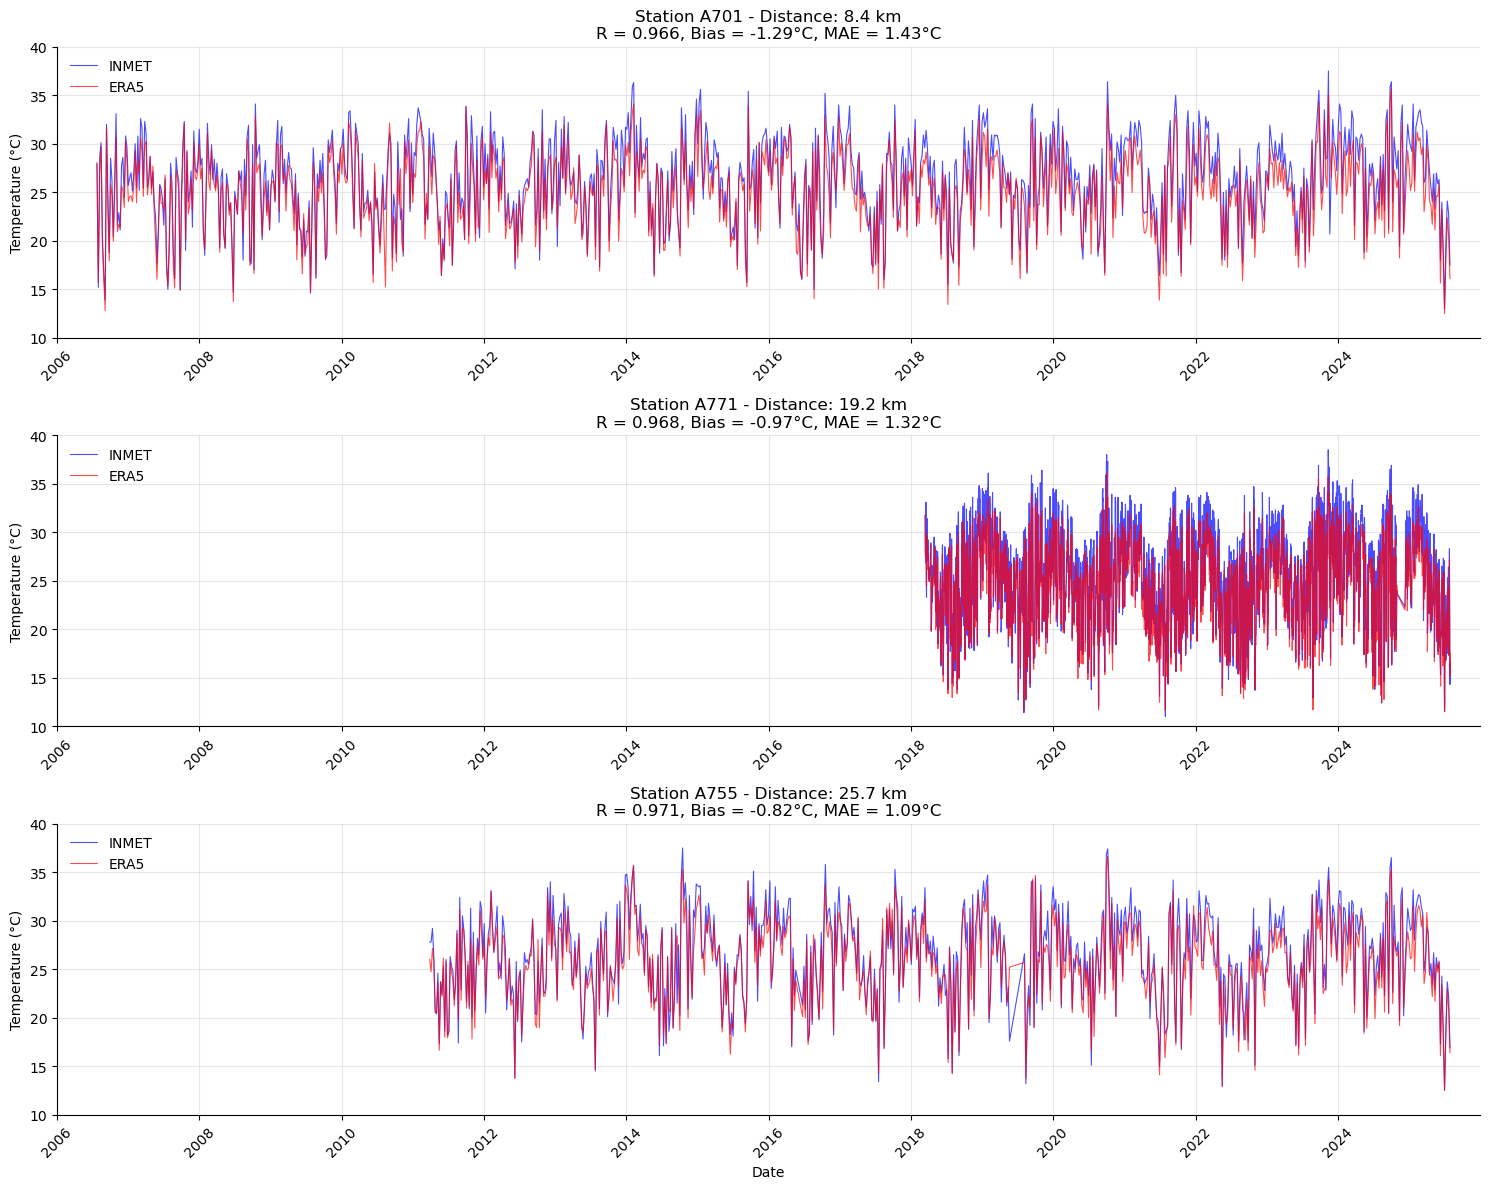


Detailed analysis for closest station A701:


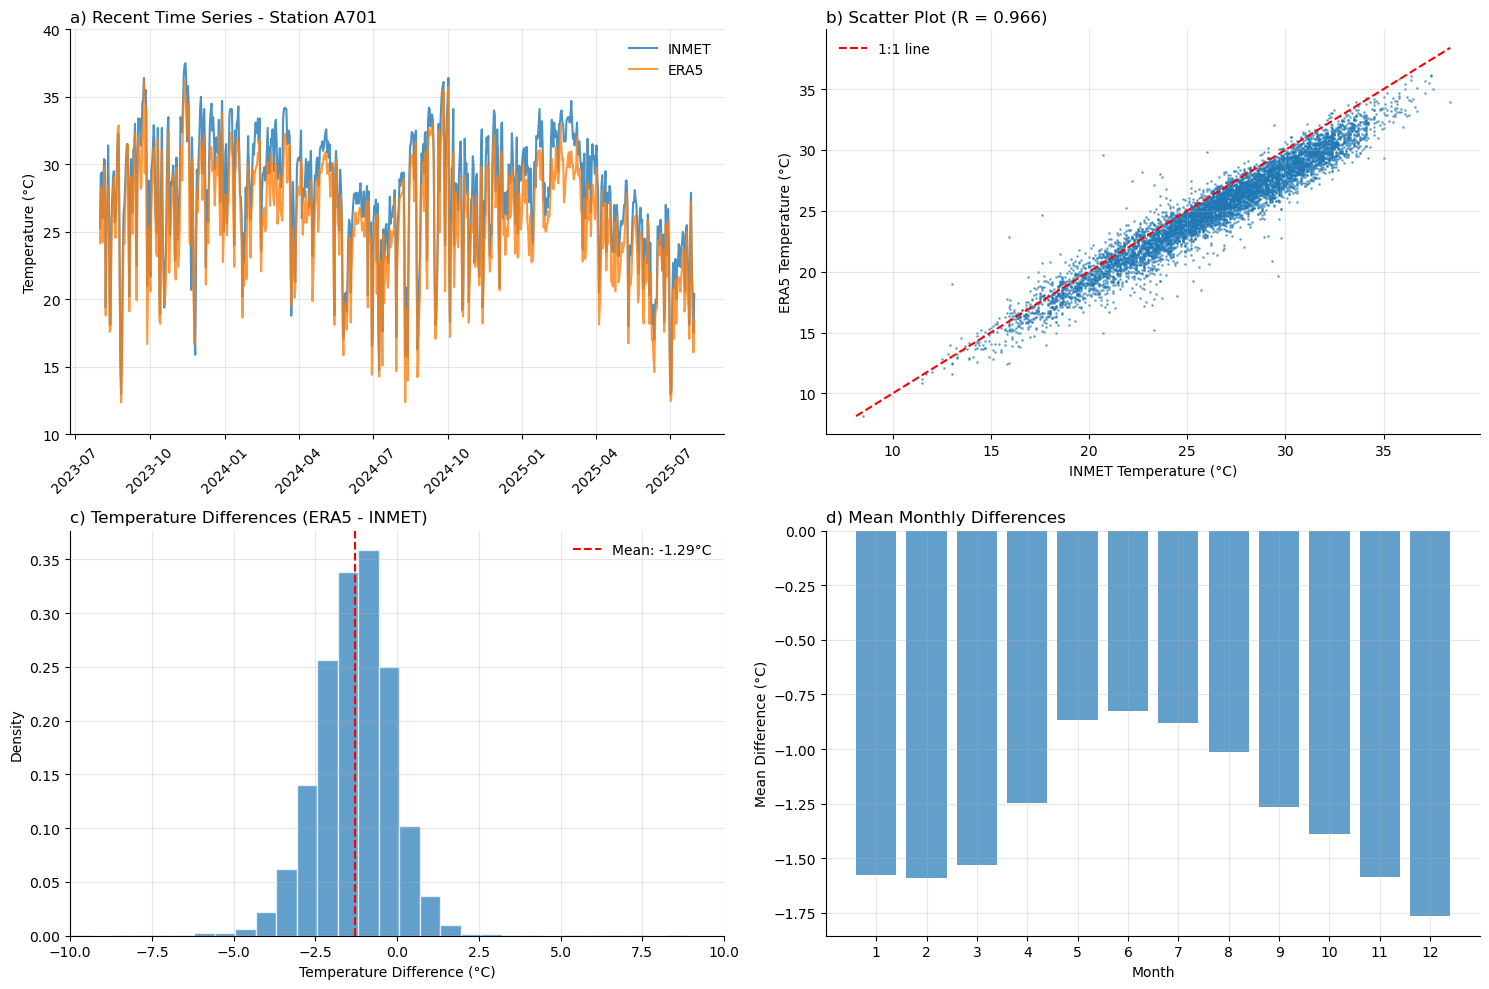

  Total data points: 6932
  Date range: 2006-07-25 00:00:00 to 2025-07-31 00:00:00
  Correlation: 0.966
  Bias: -1.29°C
  MAE: 1.43°C
  RMSE: 1.74°C


In [26]:
sao_paulo_lat = -23.5558
sao_paulo_lon = -46.6396

print(f"São Paulo coordinates: {sao_paulo_lat}, {sao_paulo_lon}")

stations_meta['distance_to_sp'] = np.sqrt(
    (stations_meta['latitude'] - sao_paulo_lat)**2 + 
    (stations_meta['longitude'] - sao_paulo_lon)**2
)

closest_stations = stations_meta.nsmallest(3, 'distance_to_sp')
print(f"\nClosest stations to São Paulo:")
for _, station in closest_stations.iterrows():
    distance_km = station['distance_to_sp'] * 111  # Rough conversion to km
    print(f"  {station['station_id']}: ({station['latitude']:.3f}, {station['longitude']:.3f}) - {distance_km:.1f} km")

fig, axes = plt.subplots(3, 1, figsize=(15, 12))

for idx, (_, station) in enumerate(closest_stations.iterrows()):
    station_id = station['station_id']
    
    station_data = comparison_df[comparison_df['station_id'] == station_id].copy()
    
    if len(station_data) == 0:
        print(f"No data available for station {station_id}")
        continue
    
    station_data = station_data.sort_values('date')
    
    ax = axes[idx]
    
    if len(station_data) > 3650:  # More than 10 years
        station_data_sample = station_data.iloc[::7]
    else:
        station_data_sample = station_data
    
    ax.plot(station_data_sample['date'], station_data_sample['inmet_tmax'], 
            label='INMET', alpha=0.7, linewidth=0.8, color='blue')
    ax.plot(station_data_sample['date'], station_data_sample['era5_tmax'], 
            label='ERA5', alpha=0.7, linewidth=0.8, color='red')
    
    correlation = station_data['inmet_tmax'].corr(station_data['era5_tmax'])
    bias = station_data['difference'].mean()
    mae = station_data['abs_difference'].mean()
    
    distance_km = station['distance_to_sp'] * 111
    
    ax.set_title(f'Station {station_id} - Distance: {distance_km:.1f} km\n'
                f'R = {correlation:.3f}, Bias = {bias:.2f}°C, MAE = {mae:.2f}°C')
    ax.set_ylabel('Temperature (°C)')
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=False)
    ax.set_xlim(pd.to_datetime("2006-01-01"), pd.to_datetime("2025-12-31"))
    ax.set_ylim([10, 40])
    
    ax.tick_params(axis='x', rotation=45)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    print(f"Station {station_id}: {len(station_data)} data points, "
          f"R = {correlation:.3f}, Bias = {bias:.2f}°C")

plt.xlabel('Date')
plt.tight_layout()
plt.show()

closest_station_id = closest_stations.iloc[0]['station_id']
closest_data = comparison_df[comparison_df['station_id'] == closest_station_id].copy()

if len(closest_data) > 0:
    print(f"\nDetailed analysis for closest station {closest_station_id}:")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    recent_data = closest_data.sort_values('date').tail(730)  # Last 2 years
    
    ax1 = axes[0, 0]
    ax1.plot(recent_data['date'], recent_data['inmet_tmax'], label='INMET', alpha=0.8)
    ax1.plot(recent_data['date'], recent_data['era5_tmax'], label='ERA5', alpha=0.8)
    ax1.set_title(f'a) Recent Time Series - Station {closest_station_id}', loc='left')
    ax1.set_ylabel('Temperature (°C)')
    ax1.legend(frameon=False)
    ax1.grid(True, alpha=0.3)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_ylim([10, 40])
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    ax2 = axes[0, 1]
    ax2.scatter(closest_data['inmet_tmax'], closest_data['era5_tmax'], 
               alpha=0.5, s=1)
    min_temp = min(closest_data['inmet_tmax'].min(), closest_data['era5_tmax'].min())
    max_temp = max(closest_data['inmet_tmax'].max(), closest_data['era5_tmax'].max())
    ax2.plot([min_temp, max_temp], [min_temp, max_temp], 'r--', label='1:1 line')
    correlation = closest_data['inmet_tmax'].corr(closest_data['era5_tmax'])
    ax2.set_title(f'b) Scatter Plot (R = {correlation:.3f})', loc='left')
    ax2.set_xlabel('INMET Temperature (°C)')
    ax2.set_ylabel('ERA5 Temperature (°C)')
    ax2.legend(frameon=False)
    ax2.grid(True, alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    ax3 = axes[1, 0]
    ax3.hist(closest_data['difference'], bins=30, alpha=0.7, density=True, edgecolor='white')
    ax3.axvline(closest_data['difference'].mean(), color='red', linestyle='--', 
               label=f'Mean: {closest_data["difference"].mean():.2f}°C')
    ax3.set_title('c) Temperature Differences (ERA5 - INMET)', loc='left')
    ax3.set_xlabel('Temperature Difference (°C)')
    ax3.set_ylabel('Density')
    ax3.legend(frameon=False)
    ax3.grid(True, alpha=0.3)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.set_xlim([-10, 10])
    
    ax4 = axes[1, 1]
    closest_data['month'] = closest_data['date'].dt.month
    monthly_diff = closest_data.groupby('month')['difference'].mean()
    ax4.bar(monthly_diff.index, monthly_diff.values, alpha=0.7)
    ax4.set_title('d) Mean Monthly Differences', loc='left')
    ax4.set_xlabel('Month')
    ax4.set_ylabel('Mean Difference (°C)')
    ax4.grid(True, alpha=0.3)
    ax4.set_xticks(range(1, 13))
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()
    
    print(f"  Total data points: {len(closest_data)}")
    print(f"  Date range: {closest_data['date'].min()} to {closest_data['date'].max()}")
    print(f"  Correlation: {correlation:.3f}")
    print(f"  Bias: {closest_data['difference'].mean():.2f}°C")
    print(f"  MAE: {closest_data['abs_difference'].mean():.2f}°C")
    print(f"  RMSE: {np.sqrt((closest_data['difference']**2).mean()):.2f}°C")

In [27]:
print("=== DETAILED COMPARISON ANALYSIS ===\n")

print("1. OVERALL STATISTICS:")
print(f"   Total data points: {len(comparison_df):,}")
print(f"   Stations analyzed: {comparison_df['station_id'].nunique()}")
print(f"   Date range: {comparison_df['date'].min().strftime('%Y-%m-%d')} to {comparison_df['date'].max().strftime('%Y-%m-%d')}")
print(f"   Correlation coefficient: {comparison_df['inmet_tmax'].corr(comparison_df['era5_tmax']):.4f}")

print(f"\n2. TEMPERATURE DIFFERENCES (ERA5 - INMET):")
print(f"   Mean difference: {comparison_df['difference'].mean():.3f}°C")
print(f"   Median difference: {comparison_df['difference'].median():.3f}°C")
print(f"   Standard deviation: {comparison_df['difference'].std():.3f}°C")
print(f"   Mean absolute difference: {comparison_df['abs_difference'].mean():.3f}°C")
print(f"   95th percentile of abs diff: {comparison_df['abs_difference'].quantile(0.95):.3f}°C")

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(comparison_df['inmet_tmax'], comparison_df['era5_tmax'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(comparison_df['inmet_tmax'], comparison_df['era5_tmax'])

print(f"\n3. PERFORMANCE METRICS:")
print(f"   Root Mean Square Error (RMSE): {rmse:.3f}°C")
print(f"   Mean Absolute Error (MAE): {mae:.3f}°C")
print(f"   Bias (ERA5 - INMET): {comparison_df['difference'].mean():.3f}°C")

print(f"\n4. ANALYSIS BY STATION:")
station_stats = comparison_df.groupby('station_id').agg({
    'difference': ['count', 'mean', 'std'],
    'abs_difference': 'mean',
    'inmet_tmax': ['mean', 'std'],
    'era5_tmax': ['mean', 'std']
}).round(3)

station_stats.columns = ['n_obs', 'mean_diff', 'std_diff', 'mae', 
                        'inmet_mean', 'inmet_std', 'era5_mean', 'era5_std']

print(station_stats.head(10))

print(f"\n5. SEASONAL ANALYSIS:")
comparison_df['month'] = comparison_df['date'].dt.month
seasonal_stats = comparison_df.groupby('month').agg({
    'difference': ['mean', 'std'],
    'abs_difference': 'mean'
}).round(3)

seasonal_stats.columns = ['mean_diff', 'std_diff', 'mae']
print(seasonal_stats)

comparison_df.to_csv('../data/processed/era5_inmet_comparison.csv', index=False)
station_stats.to_csv('../data/processed/era5_inmet_station_stats.csv')

print(f"\n6. FILES SAVED:")
print(f"   - Comparison data: ../data/processed/era5_inmet_comparison.csv")
print(f"   - Station statistics: ../data/processed/era5_inmet_station_stats.csv")

=== DETAILED COMPARISON ANALYSIS ===

1. OVERALL STATISTICS:
   Total data points: 220,249
   Stations analyzed: 42
   Date range: 2001-08-30 to 2025-07-31
   Correlation coefficient: 0.9302

2. TEMPERATURE DIFFERENCES (ERA5 - INMET):
   Mean difference: -0.526°C
   Median difference: -0.569°C
   Standard deviation: 1.679°C
   Mean absolute difference: 1.325°C
   95th percentile of abs diff: 3.572°C

3. PERFORMANCE METRICS:
   Root Mean Square Error (RMSE): 1.759°C
   Mean Absolute Error (MAE): 1.325°C
   Bias (ERA5 - INMET): -0.526°C

4. ANALYSIS BY STATION:
            n_obs  mean_diff  std_diff    mae  inmet_mean  inmet_std  \
station_id                                                             
A701         6932     -1.293     1.162  1.429      26.344      4.445   
A705         7985      0.153     1.273  0.931      28.801      3.957   
A706         6941      3.370     1.520  3.414      21.350      3.604   
A707         7586     -0.099     1.199  0.867      29.914      3.936   
A7

=== ANÁLISIS ESTADÍSTICO COMPLETO ===



/var/folders/8j/y_l8frxs2n19mq92k5pv4y100000gn/T/ipykernel_58479/1508837840.py:160: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax9.boxplot(station_diffs, labels=stats_df['station_id'])


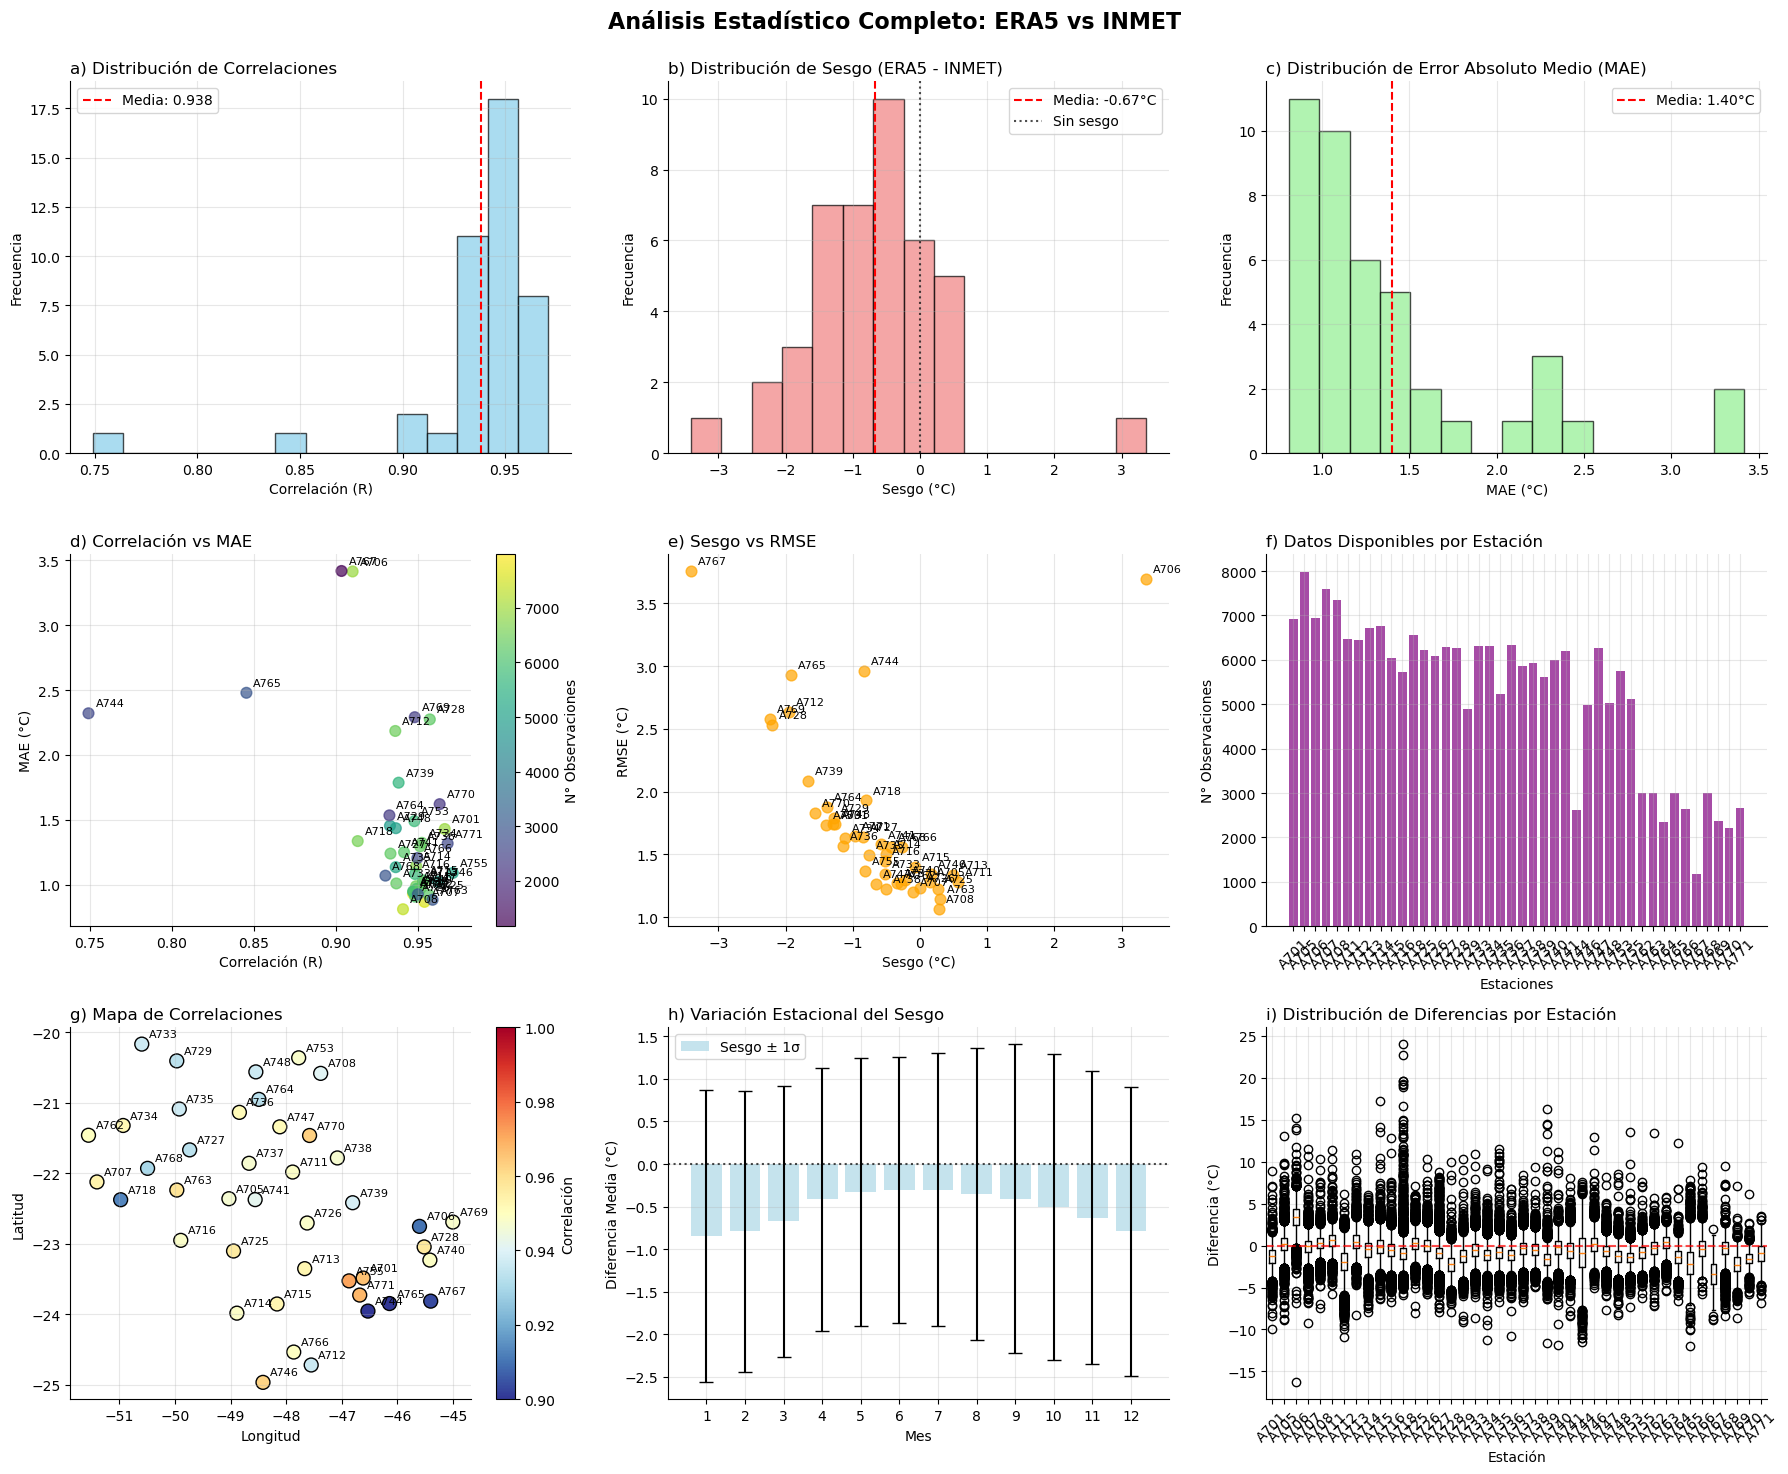


=== RESUMEN ESTADÍSTICO GENERAL ===
Número total de estaciones: 42
Número total de observaciones: 220,249
Período analizado: 2001-08-30 a 2025-07-31

CORRELACIÓN:
  Media: 0.9384
  Mediana: 0.9480
  Rango: 0.7491 - 0.9711

SESGO (ERA5 - INMET):
  Media: -0.674°C
  Mediana: -0.615°C
  Desv. estándar: 1.051°C
  Rango: -3.407°C - 3.370°C

ERROR ABSOLUTO MEDIO (MAE):
  Media: 1.399°C
  Mediana: 1.175°C
  Rango: 0.811°C - 3.418°C

RMSE:
  Media: 1.738°C
  Mediana: 1.557°C
  Rango: 1.064°C - 3.758°C

Estadísticas guardadas en: ../data/processed/era5_inmet_station_statistics.csv


In [33]:
print("=== ANÁLISIS ESTADÍSTICO COMPLETO ===\n")

# Calcular estadísticas por estación
station_stats = []
for station_id in comparison_df['station_id'].unique():
    station_data = comparison_df[comparison_df['station_id'] == station_id]
    
    correlation = station_data['inmet_tmax'].corr(station_data['era5_tmax'])
    bias = station_data['difference'].mean()
    mae = station_data['abs_difference'].mean()
    rmse = np.sqrt(mean_squared_error(station_data['inmet_tmax'], station_data['era5_tmax']))
    std_diff = station_data['difference'].std()
    n_obs = len(station_data)
    
    # Agregar coordenadas de la estación
    station_meta = stations_meta[stations_meta['station_id'] == station_id].iloc[0]
    
    station_stats.append({
        'station_id': station_id,
        'n_observations': n_obs,
        'correlation': correlation,
        'bias': bias,
        'mae': mae,
        'rmse': rmse,
        'std_diff': std_diff,
        'latitude': station_meta['latitude'],
        'longitude': station_meta['longitude']
    })

stats_df = pd.DataFrame(station_stats)

# Crear visualizaciones
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Análisis Estadístico Completo: ERA5 vs INMET\n', fontsize=16, fontweight='bold')

# 1. Distribución de correlaciones
ax1 = axes[0, 0]
ax1.hist(stats_df['correlation'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(stats_df['correlation'].mean(), color='red', linestyle='--', 
           label=f'Media: {stats_df["correlation"].mean():.3f}')
ax1.set_title('a) Distribución de Correlaciones', loc='left')
ax1.set_xlabel('Correlación (R)')
ax1.set_ylabel('Frecuencia')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Distribución de bias
ax2 = axes[0, 1]
ax2.hist(stats_df['bias'], bins=15, alpha=0.7, color='lightcoral', edgecolor='black')
ax2.axvline(stats_df['bias'].mean(), color='red', linestyle='--',
           label=f'Media: {stats_df["bias"].mean():.2f}°C')
ax2.axvline(0, color='black', linestyle=':', alpha=0.7, label='Sin sesgo')
ax2.set_title('b) Distribución de Sesgo (ERA5 - INMET)', loc='left')
ax2.set_xlabel('Sesgo (°C)')
ax2.set_ylabel('Frecuencia')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Distribución de MAE
ax3 = axes[0, 2]
ax3.hist(stats_df['mae'], bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
ax3.axvline(stats_df['mae'].mean(), color='red', linestyle='--',
           label=f'Media: {stats_df["mae"].mean():.2f}°C')
ax3.set_title('c) Distribución de Error Absoluto Medio (MAE)', loc='left')
ax3.set_xlabel('MAE (°C)')
ax3.set_ylabel('Frecuencia')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Correlación vs MAE
ax4 = axes[1, 0]
scatter = ax4.scatter(stats_df['correlation'], stats_df['mae'], 
                     c=stats_df['n_observations'], s=60, alpha=0.7, cmap='viridis')
ax4.set_xlabel('Correlación (R)')
ax4.set_ylabel('MAE (°C)')
ax4.set_title('d) Correlación vs MAE', loc='left')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.grid(True, alpha=0.3)
# Agregar etiquetas de estaciones
for _, row in stats_df.iterrows():
    ax4.annotate(row['station_id'], (row['correlation'], row['mae']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('N° Observaciones')

# 5. Bias vs RMSE
ax5 = axes[1, 1]
ax5.scatter(stats_df['bias'], stats_df['rmse'], s=60, alpha=0.7, color='orange')
ax5.set_xlabel('Sesgo (°C)')
ax5.set_ylabel('RMSE (°C)')
ax5.set_title('e) Sesgo vs RMSE', loc='left')
ax5.grid(True, alpha=0.3)
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
for _, row in stats_df.iterrows():
    ax5.annotate(row['station_id'], (row['bias'], row['rmse']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 6. Número de observaciones por estación
ax6 = axes[1, 2]
bars = ax6.bar(range(len(stats_df)), stats_df['n_observations'], alpha=0.7, color='purple')
ax6.set_xlabel('Estaciones')
ax6.set_ylabel('N° Observaciones')
ax6.set_title('f) Datos Disponibles por Estación', loc='left')
ax6.set_xticks(range(len(stats_df)))
ax6.set_xticklabels(stats_df['station_id'], rotation=45)
ax6.grid(True, alpha=0.3)
ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)

# 7. Mapa de estaciones coloreado por correlación
ax7 = axes[2, 0]
scatter_map = ax7.scatter(stats_df['longitude'], stats_df['latitude'], 
                         c=stats_df['correlation'], s=100, cmap='RdYlBu_r', 
                         vmin=0.9, vmax=1.0, edgecolors='black')
ax7.set_xlabel('Longitud')
ax7.set_ylabel('Latitud')
ax7.set_title('g) Mapa de Correlaciones', loc='left')
ax7.grid(True, alpha=0.3)
ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)
for _, row in stats_df.iterrows():
    ax7.annotate(row['station_id'], (row['longitude'], row['latitude']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)
cbar_map = plt.colorbar(scatter_map, ax=ax7)
cbar_map.set_label('Correlación')

# 8. Análisis temporal: diferencias por mes
ax8 = axes[2, 1]
monthly_stats = comparison_df.groupby(comparison_df['date'].dt.month).agg({
    'difference': ['mean', 'std'],
    'abs_difference': 'mean'
})
monthly_stats.columns = ['mean_diff', 'std_diff', 'mae']

x = monthly_stats.index
ax8.bar(x, monthly_stats['mean_diff'], alpha=0.7, color='lightblue', 
        yerr=monthly_stats['std_diff'], capsize=5, label='Sesgo ± 1σ')
ax8.axhline(0, color='black', linestyle=':', alpha=0.7)
ax8.set_xlabel('Mes')
ax8.set_ylabel('Diferencia Media (°C)')
ax8.set_title('h) Variación Estacional del Sesgo', loc='left')
ax8.set_xticks(range(1, 13))
ax8.legend()
ax8.grid(True, alpha=0.3)
ax8.spines['top'].set_visible(False)
ax8.spines['right'].set_visible(False)

# 9. Box plot de diferencias por estación
ax9 = axes[2, 2]
station_diffs = [comparison_df[comparison_df['station_id'] == sid]['difference'].values 
                for sid in stats_df['station_id']]
box_plot = ax9.boxplot(station_diffs, labels=stats_df['station_id'])
ax9.set_xlabel('Estación')
ax9.set_ylabel('Diferencia (°C)')
ax9.set_title('i) Distribución de Diferencias por Estación', loc='left')
ax9.tick_params(axis='x', rotation=45)
ax9.grid(True, alpha=0.3)
ax9.axhline(0, color='red', linestyle='--', alpha=0.7)
ax9.spines['top'].set_visible(False)
ax9.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# Resumen estadístico
print(f"\n=== RESUMEN ESTADÍSTICO GENERAL ===")
print(f"Número total de estaciones: {len(stats_df)}")
print(f"Número total de observaciones: {len(comparison_df):,}")
print(f"Período analizado: {comparison_df['date'].min().strftime('%Y-%m-%d')} a {comparison_df['date'].max().strftime('%Y-%m-%d')}")

print(f"\nCORRELACIÓN:")
print(f"  Media: {stats_df['correlation'].mean():.4f}")
print(f"  Mediana: {stats_df['correlation'].median():.4f}")
print(f"  Rango: {stats_df['correlation'].min():.4f} - {stats_df['correlation'].max():.4f}")

print(f"\nSESGO (ERA5 - INMET):")
print(f"  Media: {stats_df['bias'].mean():.3f}°C")
print(f"  Mediana: {stats_df['bias'].median():.3f}°C")
print(f"  Desv. estándar: {stats_df['bias'].std():.3f}°C")
print(f"  Rango: {stats_df['bias'].min():.3f}°C - {stats_df['bias'].max():.3f}°C")

print(f"\nERROR ABSOLUTO MEDIO (MAE):")
print(f"  Media: {stats_df['mae'].mean():.3f}°C")
print(f"  Mediana: {stats_df['mae'].median():.3f}°C")
print(f"  Rango: {stats_df['mae'].min():.3f}°C - {stats_df['mae'].max():.3f}°C")

print(f"\nRMSE:")
print(f"  Media: {stats_df['rmse'].mean():.3f}°C")
print(f"  Mediana: {stats_df['rmse'].median():.3f}°C")
print(f"  Rango: {stats_df['rmse'].min():.3f}°C - {stats_df['rmse'].max():.3f}°C")

# Guardar estadísticas
stats_df.to_csv('../data/processed/era5_inmet_station_statistics.csv', index=False)
print(f"\nEstadísticas guardadas en: ../data/processed/era5_inmet_station_statistics.csv")